# RNN

Objective: Build an RNN model to predict the next character in a sequence of text data from Shakespeare's plays.

# Data Preprocessing
Here I implement some preprocessing functions.
Running the following code loads the text data from the file "shakespeare.txt".

In [ ]:
import numpy as np
! pip install unidecode
import unidecode
import string
import time
import torch
import pdb

import torch.nn as nn
from torch.autograd import Variable
np.random.seed(123)

all_characters = string.printable
print(all_characters)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [ ]:
def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file

file = read_file("shakespeare.txt")
file_len = len(file)
print(f"file length: {file_len}")
print(file[:100])

file length: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


## Implementing function to get a random chunk of Shakespeare text
The `get_random_chunk` function is a helper function that generates a random chunk of **input text data** and **output text data** (which is one character shifted from the input) from the Shakespeare dataset.
Specifically, the `chunk_len` argument specifies the size of the input and output sequences.
For example, if `chunk_len=4`, then a valid return value would be the two chunks:
`('Befo','efor')` or `('proc','roce')`.
This function is useful
in generating diverse sets of input data for training the RNN model.

In [ ]:
def get_random_chunk(file, chunk_len = 100):
    ######### Your Code Here ###########
    start_idx = torch.randint(len(file) - chunk_len - 1, (1,))

    chunk1 = file[start_idx:start_idx + chunk_len]
    chunk2 = file[start_idx + 1:start_idx + chunk_len + 1]

    return chunk1, chunk2
    ######### End of your code #########

curr_chunk, next_chunk = get_random_chunk(file='Hello world!', chunk_len=10)
print(f"curr_chunk =>{curr_chunk}\n next_chunk=> {next_chunk}")

print(f"Is curr_chunk and next_chunk same length: {len(curr_chunk) == len(next_chunk)}")
print(f"Is next chunk shifted by one: {curr_chunk[1:] == next_chunk[:-1]}")


curr_chunk =>Hello worl
 next_chunk=> ello world
Is curr_chunk and next_chunk same length: True
Is next chunk shifted by one: True


### Implement function to convert to tensors

Defined a function `to_tensor(string)` that takes a string of characters as input and return torch tensor as output.
Specifically,
1. Creates an empty tensor of shape `(len(string), 1, len(all_characters))` using the PyTorch `torch.zeros` function,
    where `len(string)` is the length of the input string, 1 is the batch size, and `len(all_characters)` is the total
    number of unique characters in the text data.
2. Loops through each character in the input string and convert it to a one-hot encoded vector.

In [ ]:
def to_tensor(string):

  tensor = torch.zeros(len(string), 1, len(all_characters))

  for li, letter in enumerate(string):
    tensor[li][0][all_characters.find(letter)] = 1

  return tensor


def get_one_hot_tensors(input, output):
    return to_tensor(input), to_tensor(output)

input, output = get_random_chunk(file, 50)
print(input.replace('\n', ' '))
print(output.replace('\n', ' '))
input_tensor, output_tensor = get_one_hot_tensors(input, output)
print(f"input shape: {input_tensor.shape}")
print(f"output shape: {output_tensor.shape}")

ve but that I was in hell, Such terrible impressio
e but that I was in hell, Such terrible impression
input shape: torch.Size([50, 1, 100])
output shape: torch.Size([50, 1, 100])


# Build the RNN model

Here I build the RNN model using PyTorch.
- nn.GRU is used to implement the GRU algorithm for processing sequential input data.
    - https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
- I am only implementing a single layer RNN, the model is not powerful enough to learn long-term dependencies in the text data. So the output sentences are not very meaningful.

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.rnn_cell = nn.GRU(input_size, hidden_size, n_layers)
        # Define a linear decoder layer that maps from the hidden size to the output size
        self.dec = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):

        input = input.view(1, 1, -1)
        input, hidden = self.rnn_cell(input, hidden)
        output = self.dec(input.view(1, -1))

        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
def train(inp, target, decoder):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    input_tensor, target_tensor = get_one_hot_tensors(inp, target)
    for c in range(len(inp)):
        output, hidden = decoder(input_tensor[c], hidden)
        loss += criterion(output, torch.argmax(target_tensor[c]).unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()
    return loss.item() / max_length

In [ ]:
def evaluate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = to_tensor(prime_str)
    predicted = prime_str

    # Using priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        out, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = to_tensor(predicted_char)

    return predicted

[(100 5.0%) 2.9177728271484376]
Whe, ton:
Kbet heRgere
d wos toud irr yonde oind, gor  hop BhunTuthe sisd ho aionathot io thsee meher
 

[(200 10.0%) 2.3217930603027344]
Wharh, tid fhos ind sfaf thes ild thecy th, the lhat thillle depr thet ire whillgand therithe thing, w 

[(300 15.0%) 2.2633753967285157]
Whe pio thou por perest andenonest:
dous ecer be fhes some, sicheras mere me sarout ais you thou my ra 

[(400 20.0%) 2.8528561401367187]
Whes dern desth,
Fom fid cyou hace how thepst. Came.

Cand my way month r'cand pore dyou cois waseng t 

[(500 25.0%) 2.467253875732422]
Wht, 'ss mall hant.

KING RIUIDA:
Af mbors you wo ker, Oo thar she pors on bert berdis? Yom af'd borer 

[(600 30.0%) 2.4357199096679687]
Whe pravam isto, bat blicings for sor pray and sors ark, thermell, outh year whis cor of sere hix's wi 

[(700 35.0%) 2.0511407470703125]
What wirg ofow wrid my pertanttercod libut in.

GLESES:
And canem, wist makn;
Thou bane, concous ente  

[(800 40.0%) 1.9258375549316407]
Whi

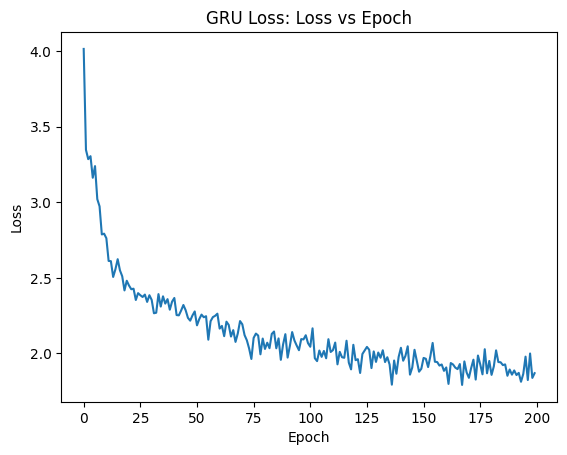

In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005
max_length = len(all_characters)

decoder = RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file), decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title("GRU Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Implement an LSTM model

Creating my own LSTM cell module using learnt equuations.
The code below will use this instead of the GRU cell module and train the model.

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.xh = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.hh = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hidden=None):
        # Unpack hidden state and cell state
        hx, cx = hidden

        # Apply linear layers to input and hidden state
        linear = self.xh(input) + self.hh(hx)

        # Get outputs of applying a linear transform for each part of the LSTM
        input_linear, forget_linear, cell_linear, output_linear = linear.reshape(-1).chunk(4)


        cell_linear = torch.tanh(cell_linear)
        input_linear = torch.sigmoid(input_linear)
        forget_linear = torch.sigmoid(forget_linear)
        output_linear = torch.sigmoid(output_linear)

        c_new = (forget_linear * cx) + (input_linear * cell_linear)

        h_new = output_linear * torch.tanh(c_new)

        # Pack cell state $C_t$ and hidden state $h_t$ into a single hidden state tuple
        output = h_new # For LSTM the output is just the hidden state
        hidden = (h_new, c_new) # Packed h and C
        return output, hidden



[(100 5.0%) 3.960457763671875]
Wh,7tlnTa re  yf  eeea Tor k- hhetul E
 AAtdsgtah t  tm oedbdew iedeuSoo
 rTsttmo  iielo n CdeE  
aeoa 

[(200 10.0%) 3.2245941162109375]
Whdc,
sCG uoeeo 
r eee 
li tRn,oy A UA 
 hseallr e . cs. t ytrt
WmnL tofes er   m
antEa yu p y oeu,i r 

[(300 15.0%) 2.9685406494140625]
Whe:m eor or rooe  oh  she ohr,m
t'e ea itneat
 Wo:l ase doy ipd 
n sohn oveeeltiitathiead afrei
e,hsC 

[(400 20.0%) 2.937818908691406]
WheP
awps ooRt ohe ret eanrra iei'sith ay aoad m
tti auatt mhe 
loe pa yelrh thlhe ad
Moseorlcothothot 

[(500 25.0%) 3.222981262207031]
Whvgn noo 'se rt sd tiol ean
,
ale. fa ebthem whe so na s laly m m  atpood rhe ts hoswsso uoe or wte r 

[(600 30.0%) 2.6239453125]
Wht, tar sor she cland ywbry teeorsyd rovans nou lre saicar tin eau, bud , thyehe ne  eosidug

bang yo 

[(700 35.0%) 2.4271469116210938]
Whorsaalt iy the:ou toy mhat in me orselnsdcase 
nat we shutd hy weecnsetrode,

mreeragee,
Llle the.

 

[(800 40.0%) 2.4408917236328125]
Whild a the

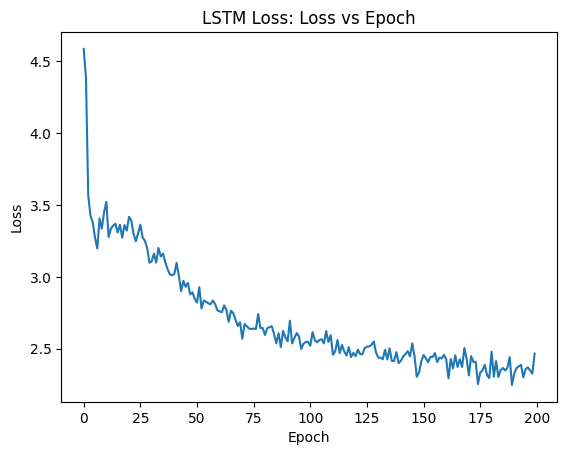

In [ ]:
lr = 0.001
class LSTM_RNN(RNN):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Replace the gru cell with LSTM cell
        self.rnn_cell = LSTMCell(max_length, hidden_size, max_length)

    def init_hidden(self):
        # LSTM cells need two hidden variables in a tuple of (h_t,C_t)
        return (Variable(torch.zeros(1, 1, self.hidden_size)), Variable(torch.zeros(1, 1, self.hidden_size)))

decoder = LSTM_RNN(max_length, hidden_size, max_length)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*get_random_chunk(file),decoder)
    loss_avg += loss

    if epoch % print_every == 0:
        print(f"[({epoch} {epoch / n_epochs * 100}%) {loss}]")
        print(evaluate(decoder, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

print(f"______________________________________________________________")
print(evaluate(decoder, 'Th', 200, temperature=0.2))

plt.plot(all_losses)
plt.title("LSTM Loss: Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()